In [4]:
import sys
import os
import importlib
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab

# pyaldata
sys.path.append("/home/zms24/Desktop") 
import PyalData.pyaldata as pyal # type:ignore

# tools functions
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from tools.curbd import curbd
from tools.dsp.preprocessing import preprocess
from tools.rnn_and_curbd import rnn as rnnz
from tools.rnn_and_curbd import plotting as pltz
from tools.rnn_and_curbd import model_analysis as analyz
from tools.rnn_and_curbd import curbd as curbdz

# Reload modules
importlib.reload(rnnz)
importlib.reload(pltz)
importlib.reload(analyz)
importlib.reload(curbdz)

np.random.seed(0)

#### color palette

In [5]:
curbd_colors = {'M1': "#3681D2", 'SSp': '#f4a261', 'CP': "#8ed74d", 'VAL': '#e76f51'}
model_color = '#00ff7f'
exp_color = '#232333'
trial_color = '#98fb98'
top_sol_color = "#ed6bbe"
bottom_sol_color = "#b66cea"
color_palette = {'curbd_colors': curbd_colors, 
                 'model_color': model_color, 
                 'exp_color': exp_color,
                 'trial_color': trial_color,
                 'top_sol_color': top_sol_color,
                 'bottom_sol_color': bottom_sol_color
                 }

### M044 models

In [6]:
filename = 'rnn_model_M044_2024_12_04_09_30.mat'
path = os.path.join("/home/zms24/Desktop/rnn_models/", filename)

data = loadmat(path, simplify_cells=True)
rnn_model = data['rnn_model']

### M061 models

In [7]:
fname0 = 'rnn_model_M061_2025_03_04_10_00.mat'
fname1 = 'rnn_model_M061_2025_03_06_14_00.mat'
path0 = os.path.join("/home/zms24/Desktop/rnn_models/", fname0)
path1 = os.path.join("/home/zms24/Desktop/rnn_models/", fname1)

data0 = loadmat(path0, simplify_cells=True)
data1 = loadmat(path1, simplify_cells=True)
rnn_model0 = data0['rnn_model']
rnn_model1 = data1['rnn_model']

### M062 models

In [8]:
fname2 = 'rnn_model_M062_2025_03_19_14_00.mat'
fname3 = 'rnn_model_M062_2025_03_20_14_00.mat'
fname4 = 'rnn_model_M062_2025_03_21_14_00.mat'
path2 = os.path.join("/home/zms24/Desktop/rnn_models/", fname2)
path3 = os.path.join("/home/zms24/Desktop/rnn_models/", fname3)
path4 = os.path.join("/home/zms24/Desktop/rnn_models/", fname4)

data2 = loadmat(path2, simplify_cells=True)
data3 = loadmat(path3, simplify_cells=True)
data4 = loadmat(path4, simplify_cells=True)
rnn_model2 = data2['rnn_model']
rnn_model3 = data3['rnn_model']
rnn_model4 = data4['rnn_model']

In [9]:
def plot_model_accuracy_by_group(models_dict):
    """
    models_dict: dict with group names as keys and list of RNN models as values.
    Example: {
        "M061": [model1, model2, ...],
        "M062": [model3, model4, ...]
    }
    """
    fig = pylab.figure(figsize=[8, 3])

    colors = {
        "M044": '#00ff7f',
        "M061": "#009d56",
        "M062": "#00592d"}

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    for group_name, models in models_dict.items():
        color = colors.get(group_name, None)

        pVars_array = np.array([m['pVars'] for m in models])
        chi2s_array = np.array([m['chi2s'] for m in models])

        pVars_mean = np.mean(pVars_array, axis=0)
        pVars_sem = np.std(pVars_array, axis=0, ddof=1) / np.sqrt(len(models))

        chi2s_mean = np.mean(chi2s_array, axis=0)
        chi2s_sem = np.std(chi2s_array, axis=0, ddof=1) / np.sqrt(len(models))

        iterations = np.arange(len(pVars_mean))

        # Plot pVar
        ax1.plot(iterations, pVars_mean, label=group_name, color=color)
        ax1.fill_between(iterations, pVars_mean - pVars_sem, pVars_mean + pVars_sem, color=color, alpha=0.3)

        # Plot chi²
        ax2.plot(iterations, chi2s_mean, label=group_name, color=color)
        ax2.fill_between(iterations, chi2s_mean - chi2s_sem, chi2s_mean + chi2s_sem, color=color, alpha=0.3)

    ax1.set_ylabel("pVar", fontsize=14)
    ax1.set_xlabel("Iterations", fontsize=14)
    ax1.set_ylim(0, 1)
    ax1.legend()

    ax2.set_ylabel("chi²", fontsize=14)
    ax2.set_xlabel("Iterations", fontsize=14)
    ax2.set_ylim(0, max(ax2.get_ylim()[1], 1))
    ax2.legend()

    fig.tight_layout()
    fig.suptitle("RNN Model Accuracy — M061 vs M062", y=1.05)

/home/zms24/miniconda3/envs/zofia_earthquake_env/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zms24/miniconda3/envs/zofia_earthquake_env/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


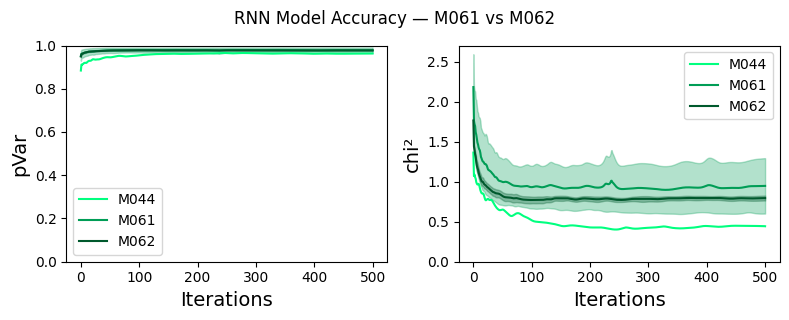

In [10]:
rnn_models_dict = {'M044': [rnn_model],
                   'M061': [rnn_model0, rnn_model1],
                   'M062': [rnn_model2, rnn_model3, rnn_model4]}
plot_model_accuracy_by_group(rnn_models_dict)


## CCA analysis

In [27]:
def cca_comparison(models_dict):
    fig = plt.figure(figsize=(5, 3))
    colors = {
        "M044": '#00ff7f',
        "M061": "#009d56",
        "M062": "#00592d"}
    
    count = 0
    for model_name, models in models_dict.items():

        for i in range(len(models)):
            model = models[i]
            model_ = model.copy()
            model_['RNN'] = rnnz.combine_rnn_time_bins(model)

            rnn_activity = model_['RNN'].T
            real_activity = model_['Adata'].T
            num_components = 474

            # PCA
            _, pca_data_real = analyz.pca_fit_transform(real_activity, num_components)
            _, pca_data_rnn = analyz.pca_fit_transform(rnn_activity, num_components)

            if count == 0: # just once
                ctrl_cca = analyz.canoncorr(pca_data_real, pca_data_real)
                plt.plot(ctrl_cca, label = "control", color = 'black')
                
            model_cca = analyz.canoncorr(pca_data_real, pca_data_rnn) 
            plt.plot(model_cca, label = model_name, color = colors[model_name], alpha = 0.5)
            count += 1

    plt.xlabel("Canonical Variable Index")
    plt.ylabel("Canonical Correlation Coefficient")
    plt.title(f"CCA analysis")
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.show()

RNN model output transformed from shape: (474, 2925) to (474, 1463). Matching the original data shape of (474, 1463)
RNN model output transformed from shape: (861, 4799) to (861, 2400). Matching the original data shape of (861, 2400)
RNN model output transformed from shape: (587, 4799) to (587, 2400). Matching the original data shape of (587, 2400)
RNN model output transformed from shape: (810, 4799) to (810, 2400). Matching the original data shape of (810, 2400)
RNN model output transformed from shape: (792, 4799) to (792, 2400). Matching the original data shape of (792, 2400)
RNN model output transformed from shape: (647, 4799) to (647, 2400). Matching the original data shape of (647, 2400)


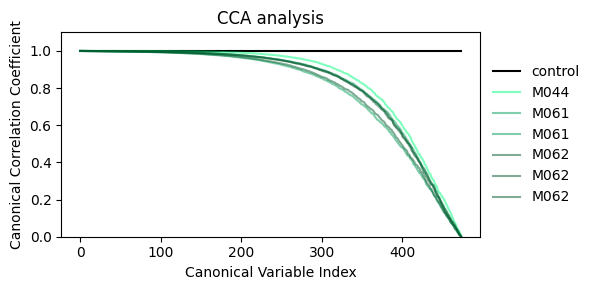

In [28]:
cca_comparison(rnn_models_dict)